In [1]:
# importing the libraries 
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import random
from torch import cuda
import config_hp as hp
from pprint import pprint
import pickle 
from  data_maker import *
WANDB_SILENT = "true"
import wandb
import torch.optim as optim
from torch.optim import lr_scheduler
wandb.login()

wandb.init(project="NNLM")

[nltk_data] Downloading package punkt to /home2/jainit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home2/jainit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home2/jainit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jain_it. Use `wandb login --relogin` to force relogin


In [2]:
class NNLM(nn.Module):
    """This class implements the Neural Network Language Model"""
    def __init__( self, glove_embeddings, hidden_layer,  n_gram, drpout= 0.5):
        super(NNLM, self).__init__()
        self.vocab_size = glove_embeddings.shape[0]
        self.embeddings_dim = glove_embeddings.shape[1]
        print(self.embeddings_dim)
        self.embeddings = nn.Embedding.from_pretrained(glove_embeddings)
        self.linear1 = nn.Linear(( self.embeddings_dim)*n_gram, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, self.vocab_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=drpout)
        self.n_gram = n_gram
        

    
    def forward(self, x):
        x = self.embeddings(x) # (batch_size, n_gram, embedding_dim)
        # print(x.shape)
        x = x.view(x.shape[0], -1) # (batch_size, n_gram*embedding_dim)
        # print(x.shape)
        x = self.linear1(x) # (batch_size, hidden_layer)
        x = self.relu1(x) # (batch_size, hidden_layer)
        x = self.dropout1(x) # (batch_size, hidden_layer) 
        x = self.linear2(x) # (batch_size, vocab_size)
       
        return x


In [3]:
class NNLM_without_pretrained(nn.Module):
    """This class implements the Neural Network Language Model"""
    def __init__( self, glove_embeddings, hidden_layer,  n_gram, drpout= 0.5):
        super(NNLM_without_pretrained, self).__init__()
        self.vocab_size = glove_embeddings.shape[0]
        self.embeddings_dim = glove_embeddings.shape[1]
        print(self.embeddings_dim)
        self.embeddings = nn.Embedding(self.vocab_size, self.embeddings_dim)
        self.linear1 = nn.Linear(( self.embeddings_dim)*n_gram, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, self.vocab_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=drpout)
        self.n_gram = n_gram
        

    
    def forward(self, x):
        x = self.embeddings(x) # (batch_size, n_gram, embedding_dim)
        # print(x.shape)
        x = x.view(x.shape[0], -1) # (batch_size, n_gram*embedding_dim)
        # print(x.shape)
        x = self.linear1(x) # (batch_size, hidden_layer)
        x = self.relu1(x) # (batch_size, hidden_layer)
        x = self.dropout1(x) # (batch_size, hidden_layer) 
        x = self.linear2(x) # (batch_size, vocab_size)
        
       
        return x


In [4]:
with open('../data/embeddings.pkl', 'rb') as f:
    glove_embeddings = pickle.load(f)

In [5]:
with open('../data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    

In [6]:
with open('../data/ngrams_dataloader.pkl', 'rb') as f:
    ngrams_dataloader = pickle.load(f)

Perplexity will be e^(cross-entropy loss per word) because the loss is the negative log likelihood of the data, and the perplexity is the inverse of the likelihood.
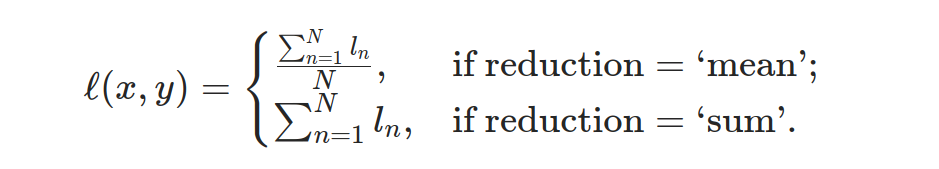


In [7]:
#training 
wandb.init(project="NNLM" , name="pretrained_withsoftmax",config = {
    "epochs": 50 ,
    "optimizer": "Adam",
    "batch_size": hp.BATCH_SIZE,
    "embeddings_dim":300,
    "drop_out":0.5,
})
initial_lr = 0.001
model = NNLM(glove_embeddings, 300, 5)
device = 'cuda' if cuda.is_available() else 'cpu'
print("The Device is {}".format(device))
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.8, verbose=True)
criterion = nn.CrossEntropyLoss()
model.train()
steps = 0
for epoch in range(1,50):
    total_loss = 0
    perp = 0
    for sentence, label in ngrams_dataloader['train']:
        steps += 1
        sentence = sentence.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(sentence)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        perp+= np.exp(loss.item())
        total_loss += loss.item()
        
    print("Epoch: {}, Loss: {} , Perplexity:{} ".format(epoch, total_loss/len(ngrams_dataloader['train']) , np.exp(total_loss/len(ngrams_dataloader['train']) )))
   
    wandb.log({"train_loss": total_loss/len(ngrams_dataloader['train']), "epoch": epoch , "lr":optimizer.param_groups[0]['lr'],"perplexity_train": (total_loss/len(ngrams_dataloader['train'])) })

    model.eval()
    total_val_loss = 0
    perp = 0
    with torch.no_grad():
        for sentence, label in ngrams_dataloader['val']:
            sentence = sentence.to(device)
            label = label.to(device)
            output = model(sentence)
            loss = criterion(output, label)
            total_val_loss += loss.item()
            perp+= np.exp(loss.item())
    scheduler.step(total_val_loss)
    print("VALID: Epoch: {}, Loss: {} , Perplexity:{} ".format(epoch, total_val_loss/len(ngrams_dataloader['val']) ,  np.exp(total_val_loss/len(ngrams_dataloader['val']) )))
    wandb.log({"val_loss": total_val_loss/len(ngrams_dataloader['val']), "epoch": epoch , "perplexity_val":  np.exp(total_val_loss/len(ngrams_dataloader['val']) )})
    if epoch%10 == 0:
        torch.save(model.state_dict(), '../data/models/model_{}.pth'.format(epoch))
        print("Model Saved")    


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


300
The Device is cuda
Epoch: 1, Loss: 5.811147005573772 , Perplexity:334.0020082134591 
VALID: Epoch: 1, Loss: 5.614186698577471 , Perplexity:274.29020783867037 
Epoch: 2, Loss: 5.553472651078348 , Perplexity:258.13240503180236 
VALID: Epoch: 2, Loss: 5.581941064286731 , Perplexity:265.5866264960935 
Epoch: 3, Loss: 5.530516093501814 , Perplexity:252.27407444287223 
VALID: Epoch: 3, Loss: 5.597369315359537 , Perplexity:269.7159357529552 
Epoch: 4, Loss: 5.51996043260919 , Perplexity:249.62515997802637 
VALID: Epoch: 4, Loss: 5.578001449061966 , Perplexity:264.5423757026311 
Epoch: 5, Loss: 5.513894607366982 , Perplexity:248.11556049358123 
VALID: Epoch: 5, Loss: 5.60228993100453 , Perplexity:271.04637481131545 
Epoch: 6, Loss: 5.514772522433141 , Perplexity:248.33348052593027 
VALID: Epoch: 6, Loss: 5.59793531729835 , Perplexity:269.8686387065273 
Epoch: 7, Loss: 5.511356930673858 , Perplexity:247.48672165081928 
Epoch 00007: reducing learning rate of group 0 to 4.0000e-03.
VALID: Epo

In [8]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,██████▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
perplexity_train,█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁
perplexity_val,█▆▇▆▇▆▆▆▅▅▅▅▆▅▄▅▆▅▄▃▂▃▄▆▃▅▅▇▅▄▅▃▄▂▃▃▄▃▂▁
train_loss,█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁
val_loss,█▆▇▆▇▆▆▆▅▅▅▅▆▅▅▅▆▅▄▃▃▄▄▆▄▅▅▇▅▄▅▃▄▂▃▃▄▃▂▁
epoch,49
lr,0.00054
perplexity_train,5.01093
perplexity_val,244.96877
train_loss,5.01093
